# Use case: CNN Classification - ImageNet

In [1]:
!pip install kaggle

In [3]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [4]:
!kaggle datasets download -d chetankv/dogs-cats-images

 98% 425M/435M [00:04<00:00, 110MB/s]
100% 435M/435M [00:04<00:00, 100MB/s]


In [5]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: dog vs cat/dataset/training_set/cats/cat.37.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/training_se

# oad the Training and Validation Data

In [6]:
# Define directories
root_dir = '/content/dog vs cat/dataset/'
train_dir = '/content/dog vs cat/dataset/training_set'
val_dir = '/content/dog vs cat/dataset/test_set'

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(train_dir, image_size=(64, 64), batch_size=32)
val_dataset = image_dataset_from_directory(val_dir, image_size=(64, 64), batch_size=32)

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# Exploratory Data Analysis (EDA)

Number of classes: 2
Number of images per class: 4000 - 4000


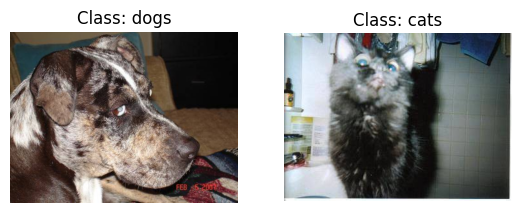

In [8]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Get class names
class_names = os.listdir(train_dir)
print(f"Number of classes: {len(class_names)}")

# Count number of images per class
class_counts = {}
for class_name in class_names:
    class_counts[class_name] = len(os.listdir(os.path.join(train_dir, class_name)))

# Display the number of images per class
print(f"Number of images per class: {min(class_counts.values())} - {max(class_counts.values())}")

# Display some samples from the dataset
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    plt.subplot(3, 3, i + 1)
    img_class = class_names[i]
    img_dir = os.path.join(train_dir, img_class)
    img_name = os.listdir(img_dir)[0]
    img = Image.open(os.path.join(img_dir, img_name))
    plt.imshow(img)
    plt.title(f"Class: {img_class}")
    plt.axis("off")
plt.show()

# Check for imbalance in the dataset

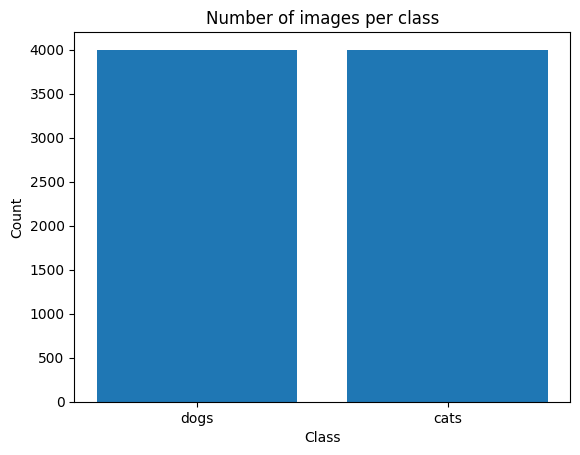

In [9]:
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Analyze image dimensions

In [10]:
import numpy as np
image_dims = []

for class_name in class_names:
    img_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(img_dir):
        img = Image.open(os.path.join(img_dir, img_name))
        image_dims.append(img.size)

# Convert to a numpy array and calculate stats
image_dims = np.array(image_dims)
print(f'Image dimensions: min={np.min(image_dims, axis=0)}, max={np.max(image_dims, axis=0)}, avg={np.mean(image_dims, axis=0)}')

Image dimensions: min=[57 41], max=[1050  768], avg=[403.801 360.472]


# Analyzing color distribution


In [11]:
color_data = []

# Use a sample of images, otherwise it may take a long time
sample_size = 100

for class_name in class_names:
    img_dir = os.path.join(train_dir, class_name)
    img_names = os.listdir(img_dir)
    np.random.shuffle(img_names)
    for img_name in img_names[:sample_size]:
        img = Image.open(os.path.join(img_dir, img_name))
        color_data.extend(np.array(img).reshape(-1, 3))

# Convert to a numpy array
color_data = np.array(color_data)

# Calculate color stats
print(f"Color data: min={np.min(color_data, axis=0)}, max={np.max(color_data, axis=0)}, avg={np.mean(color_data, axis=0)}")

Color data: min=[0 0 0], max=[255 255 255], avg=[126.36676498 117.05546047 106.96405968]


# Data Preprocessing

In [12]:
import tensorflow as tf

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Model Building

In [13]:
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator


In [14]:
# Define a data generator to handle data preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values to [0,1]
    shear_range=0.2,       # Randomly applies shearing transformation
    zoom_range=0.2,        # Randomly zooms in the image
    horizontal_flip=True)  # Randomly flips the image horizontally

test_datagen = ImageDataGenerator(rescale=1./255) # For validation/test data, only rescaling is needed

# Use the data generator to load data from directories
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # All images will be resized to 64x64
    batch_size=32,
    class_mode='binary')   # Since we use binary_crossentropy loss, we need binary labels

val_set = test_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [15]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# First Convolution Layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Dropout regularization

# Second Convolution Layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Dropout regularization

# Flattening Layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout regularization

# Output Layer
model.add(Dense(1, activation='sigmoid'))

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        36928     
                                                        

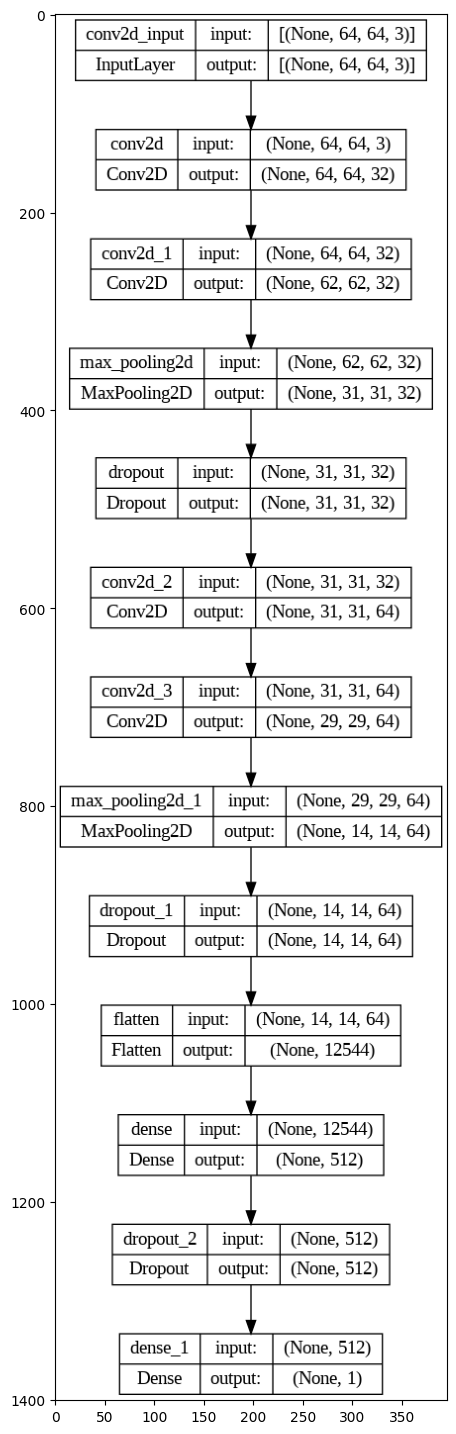

In [18]:
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plot the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image
img = mpimg.imread('model.png')
plt.figure(figsize=(10,18))
imgplot = plt.imshow(img)
plt.show()

In [19]:
# Fit the model and save the history
history= model.fit(train_set
          , steps_per_epoch=800
          , epochs=30
          , validation_data=val_set
          , validation_steps=500)

Epoch 1/30
250/800 [========>.....................] - ETA: 58s - loss: 0.7014 - accuracy: 0.4997

800/800 [==============================] - 45s 40ms/step - loss: 0.7014 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5000


# Evaluation

### Plotting Training and Validation Accuracy and Loss Over Epochs

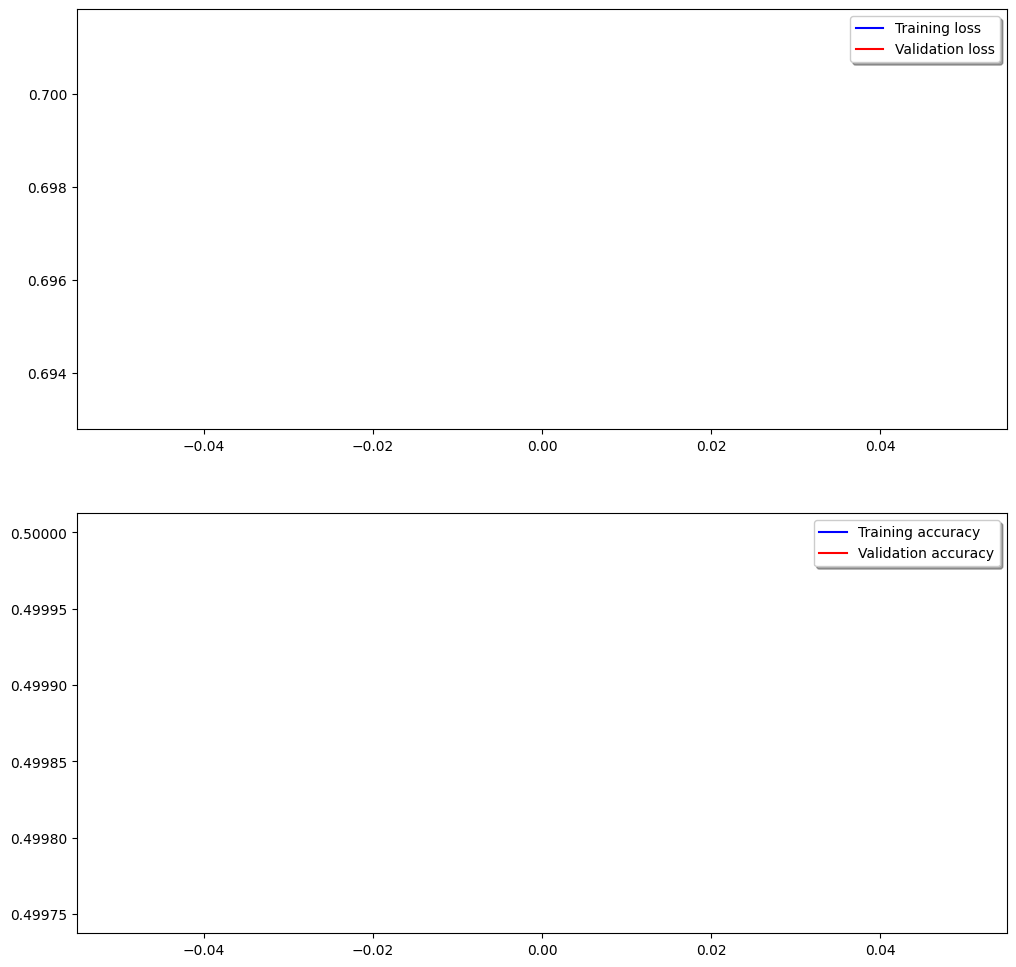

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion Matrix

63/63 [==============================] - 3s 43ms/step


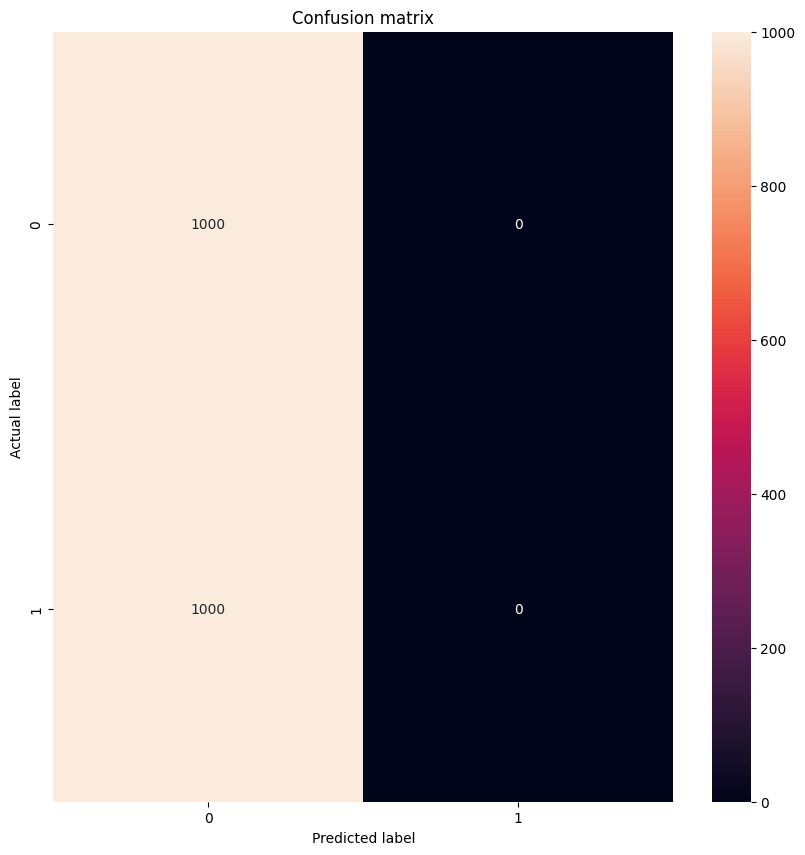

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the model predictions
predictions = model.predict(val_set)
y_pred = [1 * (x[0]>=0.5) for x in predictions]

# Get the actual labels
y_true = val_set.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

###Classification Report

In [22]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1000
           1       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 83ms/step


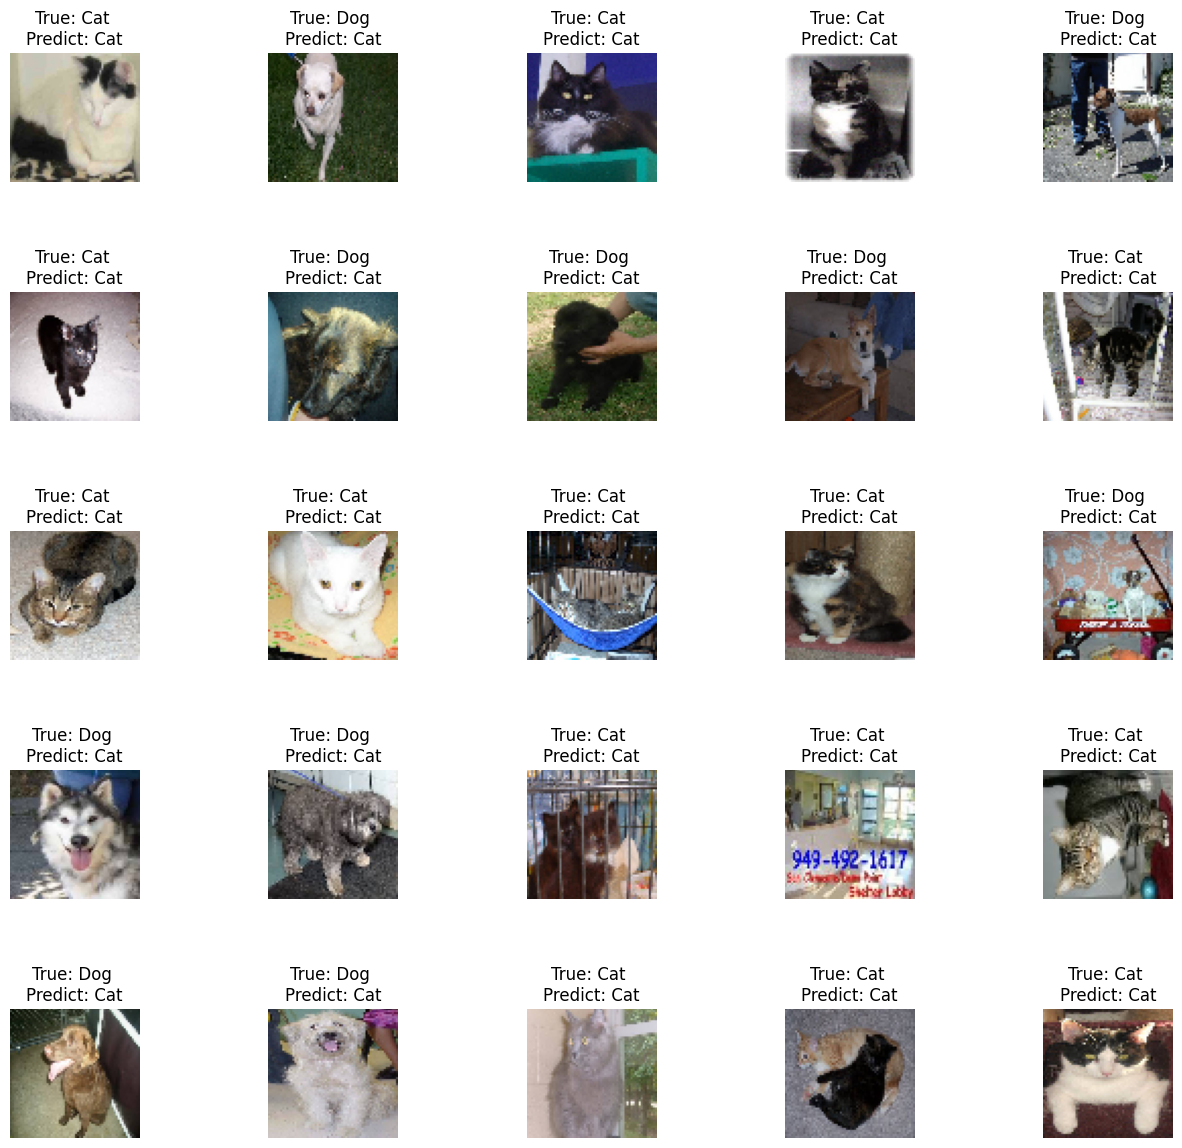

In [23]:
# Get a batch of data from the validation set
x_val_sample, y_val_sample = next(iter(val_set))

# Make predictions on the sample
y_pred_sample = model.predict(x_val_sample)
y_pred_sample_classes = [1 * (x[0]>=0.5) for x in y_pred_sample]

# Define class labels
class_labels = ['Cat', 'Dog']

# Plot the images, true labels, and predicted labels
fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(x_val_sample[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_labels[int(y_val_sample[i])], class_labels[y_pred_sample_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)